#**Problem Statement:** Develop a multilingual assistive model that helps visually impaired users by describing images in multiple Indian languages and narrating the descriptions via audio.

**Workflow:**
Use Vision Transformer (ViT)(/Any other model) to perform image classification or object detection, identifying objects in the scene.
Apply IndicTrans2(/Any other model) to translate the generated text descriptions into multiple Indian languages.

Use Whisper Model(/Any other model) to convert the text into speech and narrate the descriptions.

Dataset: You can use publicly available datasets such as MS-COCO for image-captioning tasks, which provide both images and descriptions. For Indian language translations, the FLORES dataset or IndicNLP resources can be helpful.

You are free to use any other datasets as well.

In [2]:
# Clone the required Git repository for IndicTrans2
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [3]:
# Clone the Hugging face interface from github
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [ ]:
# Install other essential dependecies for working of the transformer
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransToolkit
%cd IndicTransToolkit
!python3 -m pip install --editable ./
%cd ..

In [5]:
!pip install gTTS

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Restart the session

# Here we are generating caption of an image

In [1]:
# Image generation model
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image

img_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
img_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Image to Text Captioning
def image_to_text(image):
  inputs = img_processor(images=image, return_tensors="pt")
  out = img_model.generate(**inputs)
  return img_processor.decode(out[0], skip_special_tokens=True)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Here we are translating the generated caption to different language

In [2]:
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
)
from IndicTransToolkit import IndicProcessor


model_name = "ai4bharat/indictrans2-en-indic-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True)

ip = IndicProcessor(inference=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
src_lang, tgt_lang = "eng_Latn", "hin_Deva"

def text_translation(text, tgt_lang, src_lang="eng_Latn"):
  batch = ip.preprocess_batch(
    [text],
    src_lang=src_lang,
    tgt_lang=tgt_lang,
  )

  # Tokenize the sentences and generate input encodings
  inputs = tokenizer(
    batch,
    truncation=True,
    padding="longest",
    return_tensors="pt",
    return_attention_mask=True,
  ).to(DEVICE)

  # Generate translations using the model
  with torch.no_grad():
    generated_tokens = model.to(DEVICE).generate(
        **inputs,
        use_cache=True,
        min_length=0,
        max_length=256,
        num_beams=5,
        num_return_sequences=1,
    )

  # Decode the generated tokens into text
  with tokenizer.as_target_tokenizer():
    generated_tokens = tokenizer.batch_decode(
        generated_tokens.detach().cpu().tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

  # Postprocess the translations, including entity replacement
  translations = ip.postprocess_batch(generated_tokens, lang=tgt_lang)
  return translations[0]


tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

tokenization_indictrans.py:   0%|          | 0.00/8.10k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json:   0%|          | 0.00/645k [00:00<?, ?B/s]

dict.TGT.json:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

# Here we are converting the text to speech

In [3]:
from gtts import gTTS
from IPython.display import Audio, display

def speak(text, language='en'):
  tts = gTTS(text=text, lang=language, slow=False)
  tts.save("output.mp3")
  return Audio("output.mp3", autoplay=False)


In [4]:
import gtts

# Get a dictionary of languages supported by gtts
languages = gtts.lang.tts_langs()

# languages supported by IndicTrans2
flores_codes = {
    "asm_Beng": "as",
    "awa_Deva": "hi",
    "ben_Beng": "bn",
    "bho_Deva": "hi",
    "brx_Deva": "hi",
    "doi_Deva": "hi",
    "eng_Latn": "en",
    "gom_Deva": "kK",
    "guj_Gujr": "gu",
    "hin_Deva": "hi",
    "hne_Deva": "hi",
    "kan_Knda": "kn",
    "kas_Arab": "ur",
    "kas_Deva": "hi",
    "kha_Latn": "en",
    "lus_Latn": "en",
    "mag_Deva": "hi",
    "mai_Deva": "hi",
    "mal_Mlym": "ml",
    "mar_Deva": "mr",
    "mni_Beng": "bn",
    "mni_Mtei": "hi",
    "npi_Deva": "ne",
    "ory_Orya": "or",
    "pan_Guru": "pa",
    "san_Deva": "hi",
    "sat_Olck": "or",
    "snd_Arab": "ur",
    "snd_Deva": "hi",
    "tam_Taml": "ta",
    "tel_Telu": "te",
    "urd_Arab": "ur",
}

# Create a dictionary to store supported languages and their codes which are common supported by both gtts and IndicTrans2
supported_lang = {}

# Iterate through the languages dictionary and check for matching codes
for key, value in languages.items():
  for key1, value1 in flores_codes.items():
    if key == value1:
      supported_lang[value] = [key, key1]
      break

# get the code of lang supported by gtts
def get_item_by_value(target_value, dictionary=supported_lang):
    for key, values in dictionary.items():
        if target_value in values:
            return values[0]
    return None  # Return None if not found

# Whole Pipeline

In [5]:
# image to audio pipeline
def image_to_text_to_audio(image, lang="en_Latn"):
  tts_lang = get_item_by_value(lang)
  if tts_lang is None:
    print("Language not supported")
    return
  # get the caption
  text = image_to_text(image)
  print(f"Image Caption: {text}")

  # translate the caption to the target language
  translated_text = text_translation(text, lang)
  print(f"Translated Text: {translated_text}")

  # convert the text to speech
  audio = speak(translated_text, tts_lang)
  display(audio)


In [19]:
supported_lang

{'Bengali': ['bn', 'ben_Beng'],
 'English': ['en', 'eng_Latn'],
 'Gujarati': ['gu', 'guj_Gujr'],
 'Hindi': ['hi', 'awa_Deva'],
 'Kannada': ['kn', 'kan_Knda'],
 'Malayalam': ['ml', 'mal_Mlym'],
 'Marathi': ['mr', 'mar_Deva'],
 'Nepali': ['ne', 'npi_Deva'],
 'Punjabi (Gurmukhi)': ['pa', 'pan_Guru'],
 'Tamil': ['ta', 'tam_Taml'],
 'Telugu': ['te', 'tel_Telu'],
 'Urdu': ['ur', 'kas_Arab']}

# **Inference**

## Languages supported are:

* 'Bengali': ['bn', 'ben_Beng'], \\
* 'English': ['en', 'eng_Latn'], \\
* 'Gujarati': ['gu', 'guj_Gujr'], \\
* 'Hindi': ['hi', 'awa_Deva'], \\
* 'Kannada': ['kn', 'kan_Knda'], \\
* 'Malayalam': ['ml', 'mal_Mlym'], \\
* 'Marathi': ['mr', 'mar_Deva'], \\
* 'Nepali': ['ne', 'npi_Deva'], \\
* 'Punjabi (Gurmukhi)': ['pa', 'pan_Guru'], \\
* 'Tamil': ['ta', 'tam_Taml'], \\
* 'Telugu': ['te', 'tel_Telu'], \\
* 'Urdu': ['ur', 'kas_Arab'] \\

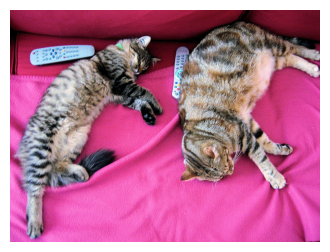

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image Caption: two cats sleeping on a couch
Translated Text: બે બિલાડીઓ કોચ પર સૂઈ રહી છે 


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [7]:
import requests
import matplotlib.pyplot as plt

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# show the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

# use the language code from the above mentioned codes
image_to_text_to_audio(image, "guj_Gujr")

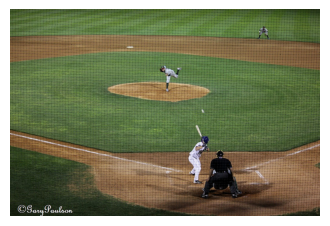

Image Caption: a baseball game is being played on a baseball field
Translated Text: ஒரு பேஸ்பால் விளையாட்டு ஒரு பேஸ்பால் மைதானத்தில் விளையாடப்படுகிறது 


In [16]:
import requests

url = 'http://images.cocodataset.org/test-stuff2017/000000025505.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# show the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

# use the language code from the above mentioned codes
image_to_text_to_audio(image, "tam_Taml")

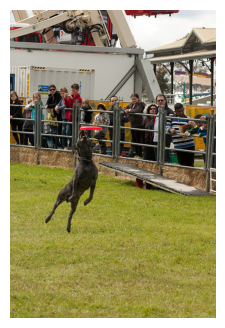

Image Caption: a dog running in the grass
Translated Text: घाँसमा दौडिरहेको कुकुर 


In [12]:
import requests

url = 'http://images.cocodataset.org/test-stuff2017/000000025527.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# show the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

# use the language code from the above mentioned codes
image_to_text_to_audio(image, "npi_Deva")

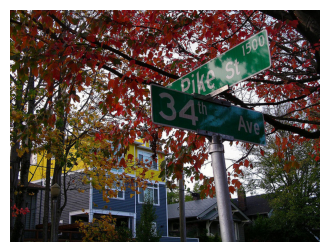

Image Caption: a street sign on a pole in front of a house
Translated Text: একটি বাড়ির সামনে একটি খুঁটির উপর একটি রাস্তার চিহ্ন 


In [15]:
import requests

url = 'http://images.cocodataset.org/test-stuff2017/000000025591.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# show the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

# use the language code from the above mentioned codes
image_to_text_to_audio(image, "ben_Beng")